In [126]:
import os
import yaml
from glob import glob
from tqdm import tqdm
from pprint import pprint
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import make_lupton_rgb

from mejiro.synthetic_image import SyntheticImage
from mejiro.exposure import Exposure
from mejiro.instruments.hst import HST
from mejiro.instruments.roman import Roman
from mejiro.instruments.lsst import LSST
from mejiro.instruments.hwo import HWO
from mejiro.utils import util

# read configuration file
with open('/grad/bwedig/mejiro/projects/pipeline/hwo.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

In [127]:
if config['dev']:
    config['pipeline_label'] += '_dev'

In [128]:
lens_dir = os.path.join(config['data_dir'], config['pipeline_label'], '02')
lenses = util.unpickle_all(lens_dir)
print(f'Found {len(lenses)} strong lens(es) in {lens_dir}')

name_snr_pairs = util.unpickle('/data/bwedig/mejiro/hwo/snr/name_snr_pairs.pkl')
snr_dict = dict(name_snr_pairs)

# Sort lenses by SNR, matching on exposure.synthetic_image.strong_lens.name
sorted_lenses = sorted(
    lenses,
    key=lambda lens: snr_dict.get(lens.name, -np.inf),
    reverse=True
)

Found 370 strong lens(es) in /data/bwedig/mejiro/hwo_dev/02


In [129]:
print(snr_dict)

{'hwo_00000105': 1135.225656242168, 'hwo_00000200': 870.5439535068108, 'hwo_00000220': 286.12114470891385, 'hwo_00000005': 247.9612428819445, 'hwo_00000244': 201.30116875343424, 'hwo_00000170': 297.61719484481404, 'hwo_00000293': 246.63311090923725, 'hwo_00000382': 287.19158555089837, 'hwo_00000231': 491.247509693775, 'hwo_00000239': 367.5275037773806, 'hwo_00000370': 321.0429995008411, 'hwo_00000632': 471.6016978064157, 'hwo_00000565': 384.8074538308667, 'hwo_00001385': 296.83801372923153, 'hwo_00000025': 651.8161297606053, 'hwo_00001363': 293.1913366155187, 'hwo_00001440': 260.302107547937, 'hwo_00001296': 700.6981255702597, 'hwo_00001444': 262.92721140034524, 'hwo_00000408': 788.5467727229412, 'hwo_00001549': 498.02411418365324, 'hwo_00000536': 357.3275442656887, 'hwo_00000882': 316.7991863387021, 'hwo_00001535': 597.2318388920496, 'hwo_00000655': 383.8422224947091, 'hwo_00001557': 570.7741781075255, 'hwo_00001509': 1212.65734306466, 'hwo_00000515': 423.83153512713017, 'hwo_00000306

In [130]:
sample = lenses[22]
pprint(sample.physical_params['magnitudes'])

{'lens': {'B': 23.689008861192406,
          'F062': 22.84367683828299,
          'F087': 21.293276424326002,
          'F106': 20.731977454677306,
          'F129': 20.347497154612988,
          'F146': 20.19633490076643,
          'F158': 20.010062367716188,
          'F184': 19.74963335909664,
          'F213': 19.56224032943399,
          'F438W': 23.70160604752993,
          'F475W': 23.672217378924444,
          'F606W': 23.100801383442658,
          'F814W': 21.697345315140723,
          'FUV': 23.989817980909272,
          'H': 19.992538219930722,
          'I': 21.430491422239264,
          'J': 20.38277696403709,
          'K': 19.54014999815368,
          'NUV': 23.85451314328278,
          'R': 21.932230877935908,
          'U': 23.857382939302184,
          'V': 23.01977696335009,
          'g': 23.66679250063556,
          'i': 22.06417394144882,
          'r': 22.92071051667657,
          'u': 23.77846566712298,
          'y': 20.941841508737866,
          'z': 21.314806

In [131]:
sample.physical_params['magnitudes']['source']['J'] -= 1.5
sample.physical_params['magnitudes']['source']['F814W'] -= 1.5
sample.physical_params['magnitudes']['source']['i'] -= 1.5

fov_arcsec = 3

In [132]:
synthetic_image_hwo = SyntheticImage(strong_lens=deepcopy(sample),
                                     instrument=HWO(),
                                     band='J',
                                     fov_arcsec=fov_arcsec,
                                     verbose=True)
# synthetic_image_hwo.plot()

Scene size: 3.0080284244368216 arcsec, 175 pixels at pixel scale 0.017188733853924696 arcsec/pix


In [133]:
synthetic_image_hst = SyntheticImage(strong_lens=deepcopy(sample),
                                 instrument=HST(),
                                 band='F814W',
                                 fov_arcsec=fov_arcsec,
                                 verbose=True)
# synthetic_image_hst.plot()

Scene size: 3.12 arcsec, 39 pixels at pixel scale 0.08 arcsec/pix


Scene size: 3.0 arcsec, 15 pixels at pixel scale 0.2 arcsec/pix


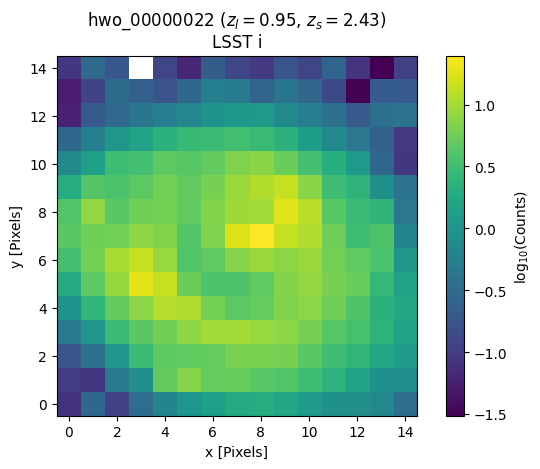

In [134]:
synthetic_image_lsst = SyntheticImage(strong_lens=deepcopy(sample),
                                 instrument=LSST(),
                                 band='i',
                                 fov_arcsec=fov_arcsec,
                                 verbose=True)
synthetic_image_lsst.plot()

Exposure calculation time with galsim engine: 0.022 s


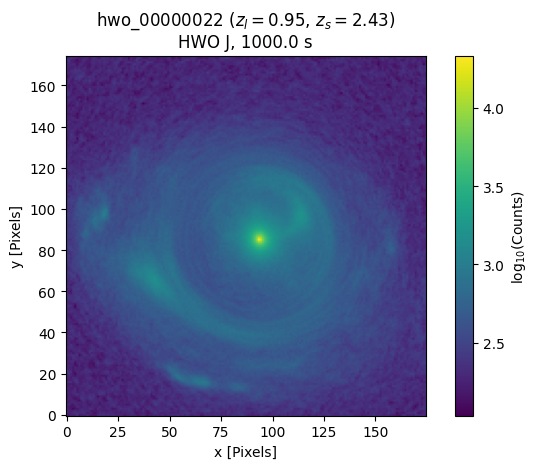

In [143]:
exposure_hwo = Exposure(synthetic_image=synthetic_image_hwo,
                        exposure_time=1e3,
                        # engine='lenstronomy',
                        verbose=True)
exposure_hwo.plot()

Exposure calculation time with lenstronomy engine: 0.006 s


/grad/bwedig/mejiro/mejiro/utils/util.py:170: UserWarning: Negative values in array have been replaced with 4.929409138376261e-05.
  warnings.warn(f"Negative values in array have been replaced with {replacement}.")


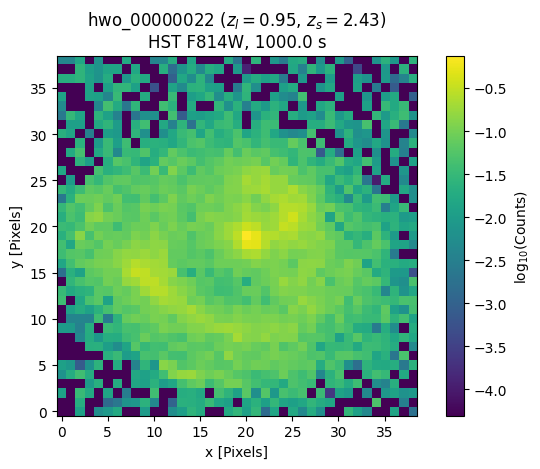

In [136]:
exposure_hst = Exposure(synthetic_image=synthetic_image_hst,
                    exposure_time=1e3,
                    engine='lenstronomy',
                    verbose=True)
exposure_hst.plot()

/grad/bwedig/mejiro/mejiro/utils/util.py:170: UserWarning: Negative values in array have been replaced with 0.01654232494964658.
  warnings.warn(f"Negative values in array have been replaced with {replacement}.")


Exposure calculation time with lenstronomy engine: 0.005 s


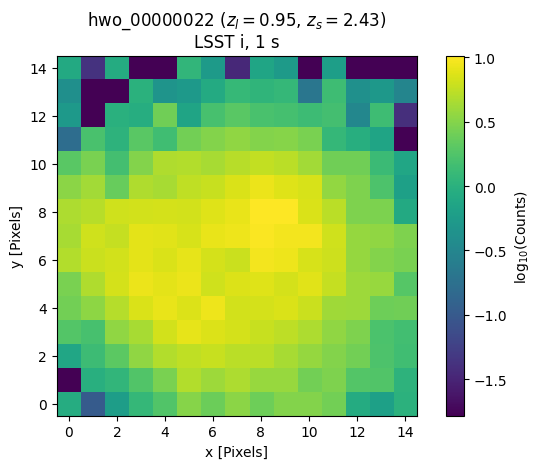

In [137]:
exposure_lsst = Exposure(synthetic_image=synthetic_image_lsst,
                    exposure_time=1,
                    engine='lenstronomy',
                    engine_params={'obs_config_kwargs': {
                    'band': 'i', 
                    'psf_type': 'GAUSSIAN', 
                    'coadd_years': 10
                }},
                    verbose=True)
exposure_lsst.plot()

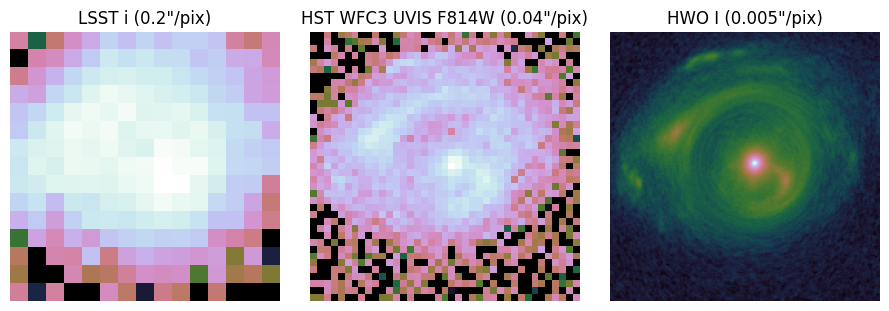

In [145]:
f, ax = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)
ax[0].imshow(np.log10(exposure_lsst.exposure),cmap='cubehelix')
ax[0].set_title('LSST i (0.2"/pix)')
ax[1].imshow(np.log10(exposure_hst.exposure),cmap='cubehelix')
ax[1].set_title('HST WFC3 UVIS F814W (0.04"/pix)')
ax[2].imshow(np.log10(exposure_hwo.exposure),cmap='cubehelix')
ax[2].set_title('HWO I (0.005"/pix)')
for a in ax.flatten():
    a.axis('off')
plt.savefig('/grad/bwedig/mejiro/projects/hwo/figures/compare_instruments.png', dpi=600)
plt.show()